In [1]:
import logging
logging.root.handlers = []  # Jupyter messes up logging so needs a reset
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
from smart_open import smart_open
import pandas as pd
import numpy as np
from numpy import random
import gensim
import nltk
from sklearn.cross_validation import train_test_split
from sklearn import linear_model
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from sklearn.neighbors import KNeighborsClassifier
from sklearn import linear_model
from nltk.corpus import stopwords
import os, codecs
%matplotlib inline
from bs4 import BeautifulSoup
import re
from nltk.corpus import stopwords

2017-02-12 20:07:57,001 : INFO : 'pattern' package found; tag filters are available for English
/usr/lib64/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
class MySentences(object):
    def __init__(self, dirname):
        self.dirname = dirname
 
    def __iter__(self):
        for fname in os.listdir(self.dirname):
            for line in codecs.open(os.path.join(self.dirname, fname)) :
                yield line.split()

In [24]:
num_features = 300
model = gensim.models.Word2Vec.load_word2vec_format('/home/bahbbc/Documents/personality_1', encoding='utf8', unicode_errors='ignore')
#model = Word2Vec.load_word2vec_format('/home/bahbbc/Documents/teste-personalidade/personality_1',binary=True)
model.init_sims(replace=True)

2017-02-12 20:11:54,677 : INFO : loading projection weights from /home/bahbbc/Documents/personality_1
2017-02-12 20:13:06,839 : INFO : loaded (288722, 300) matrix from /home/bahbbc/Documents/personality_1
2017-02-12 20:13:06,840 : INFO : precomputing L2-norms of word weight vectors


### Verify model with personality

In [25]:
df = pd.read_csv('~/personality-normalized-word2vec.csv', encoding='utf_8')
df = df.dropna()

In [26]:
df.conscientiousness_m.value_counts()

1    216
0    211
Name: conscientiousness_m, dtype: int64

In [27]:
train_data, test_data = train_test_split(df, test_size=0.3, random_state=42)

### Evaluation code

In [28]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(2)
    target_names = ['no', 'yes']
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [29]:
def evaluate_prediction(predictions, target, title="Confusion matrix"):
    print('accuracy %s' % accuracy_score(target, predictions))
    cm = confusion_matrix(target, predictions)
    print('confusion matrix\n %s' % cm)
    print('(row=expected, col=predicted)')
    
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plot_confusion_matrix(cm_normalized, title + ' Normalized')

In [30]:
def predict(vectorizer, classifier, data):
    data_features = vectorizer.transform(data['formatted_text'])
    predictions = classifier.predict(data_features)
    target = data['conscientiousness_m']
    evaluate_prediction(predictions, target)

### Word2Vec model training

In [31]:
def word_averaging(wv, words):
    all_words, mean = set(), []
    
    for word in words:
        if isinstance(word, np.ndarray):
            mean.append(word)
        elif word in wv.wv.vocab:
            mean.append(wv.wv.syn0norm[wv.wv.vocab[word].index])
            all_words.add(wv.wv.vocab[word].index)

    if not mean:
        logging.warning("cannot compute similarity with no input %s", words)
        # FIXME: remove these examples in pre-processing
        return np.zeros(num_features,)

    mean = gensim.matutils.unitvec(np.array(mean).mean(axis=0)).astype(np.float32)
    return mean

def  word_averaging_list(wv, text_list):
    return np.vstack([word_averaging(wv, review) for review in text_list ])

In [32]:
def w2v_tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text, language='portuguese'):
        for word in nltk.word_tokenize(sent, language='portuguese'):
            if len(word) < 2:
                continue
            tokens.append(word)
    return tokens

In [33]:
test_tokenized = test_data.apply(lambda r: w2v_tokenize_text(r['formatted_text']), axis=1).values
train_tokenized = train_data.apply(lambda r: w2v_tokenize_text(r['formatted_text']), axis=1).values

In [34]:
%%time
X_train_word_average = word_averaging_list(model,train_tokenized)
X_test_word_average = word_averaging_list(model,test_tokenized)

2017-02-12 20:13:22,127 : WARNING : cannot compute similarity with no input []
2017-02-12 20:13:22,414 : WARNING : cannot compute similarity with no input []
2017-02-12 20:13:22,474 : WARNING : cannot compute similarity with no input []


CPU times: user 1.62 s, sys: 18 ms, total: 1.64 s
Wall time: 1.64 s


In [35]:
%%time
logreg = linear_model.LogisticRegression(n_jobs=1, C=1e5)

logreg = logreg.fit(X_train_word_average, train_data['conscientiousness_m'])
predicted = logreg.predict(X_test_word_average)

CPU times: user 205 ms, sys: 1.83 ms, total: 207 ms
Wall time: 221 ms


accuracy 0.527131782946
confusion matrix
 [[22 41]
 [20 46]]
(row=expected, col=predicted)


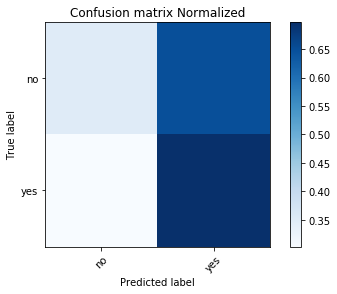

In [36]:
evaluate_prediction(predicted, test_data.conscientiousness_m)

## Remove stop words

In [37]:
def w2v_tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text, language='portuguese'):
        for word in nltk.word_tokenize(sent, language='portuguese'):
            if len(word) < 2:
                continue
            if word in stopwords.words('portuguese'):
                continue
            tokens.append(word)
    return tokens

In [38]:
test_tokenized = test_data.apply(lambda r: w2v_tokenize_text(r['formatted_text']), axis=1).values
train_tokenized = train_data.apply(lambda r: w2v_tokenize_text(r['formatted_text']), axis=1).values

In [39]:
%%time
X_train_word_average = word_averaging_list(model,train_tokenized)
X_test_word_average = word_averaging_list(model,test_tokenized)

2017-02-12 20:15:44,557 : WARNING : cannot compute similarity with no input []
2017-02-12 20:15:44,757 : WARNING : cannot compute similarity with no input []
2017-02-12 20:15:44,800 : WARNING : cannot compute similarity with no input []


CPU times: user 1.73 s, sys: 5.15 ms, total: 1.73 s
Wall time: 1.76 s


In [40]:
%%time
logreg = linear_model.LogisticRegression(n_jobs=1, C=1e5)

logreg = logreg.fit(X_train_word_average, train_data['conscientiousness_m'])
predicted = logreg.predict(X_test_word_average)

CPU times: user 334 ms, sys: 16.4 ms, total: 350 ms
Wall time: 346 ms


accuracy 0.558139534884
confusion matrix
 [[30 33]
 [24 42]]
(row=expected, col=predicted)


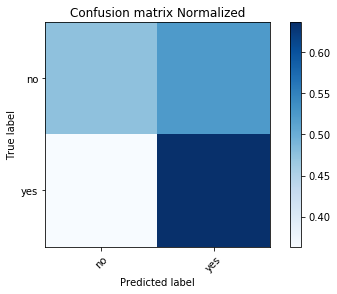

In [41]:
evaluate_prediction(predicted, test_data.conscientiousness_m)

Fitting a random forest to labeled training data...
accuracy 0.573643410853
confusion matrix
 [[29 34]
 [21 45]]
(row=expected, col=predicted)


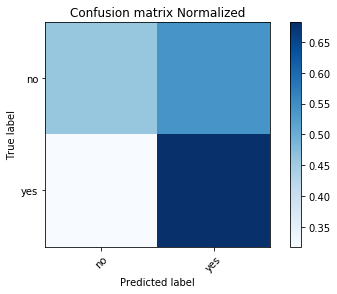

In [42]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier( n_estimators = 100 )

print "Fitting a random forest to labeled training data..."
forest = forest.fit( X_train_word_average, train_data["conscientiousness_m"] )

# Test & extract results 
result = forest.predict( X_test_word_average )

evaluate_prediction(result, test_data.conscientiousness_m)

## Doc2Vec

In [43]:
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument

In [44]:

def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if len(word) < 2:
                continue
            tokens.append(word.lower())
    return tokens

In [45]:
train_tagged = train_data.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['formatted_text']), tags=[r.conscientiousness_m]), axis=1)

In [46]:
test_tagged = test_data.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['formatted_text']), tags=[r.conscientiousness_m]), axis=1)

In [47]:
%%time
trainsent = train_tagged.values
testsent = test_tagged.values

# simple gensim doc2vec api
doc2vec_model = Doc2Vec(trainsent, workers=1, size=5, iter=20, dm=1)

train_targets, train_regressors = zip(
    *[(doc.tags[0], doc2vec_model.infer_vector(doc.words, steps=20)) for doc in trainsent])

2017-02-12 20:16:07,633 : WARNING : consider setting layer size to a multiple of 4 for greater performance
2017-02-12 20:16:07,635 : INFO : collecting all words and their counts
2017-02-12 20:16:07,638 : INFO : PROGRESS: at example #0, processed 0 words (0/s), 0 word types, 0 tags
2017-02-12 20:16:07,799 : INFO : collected 58096 word types and 2 unique tags from a corpus of 298 examples and 594855 words
2017-02-12 20:16:07,800 : INFO : Loading a fresh vocabulary
2017-02-12 20:16:08,214 : INFO : min_count=5 retains 10457 unique words (17% of original 58096, drops 47639)
2017-02-12 20:16:08,215 : INFO : min_count=5 leaves 525071 word corpus (88% of original 594855, drops 69784)
2017-02-12 20:16:08,245 : INFO : deleting the raw counts dictionary of 58096 items
2017-02-12 20:16:08,247 : INFO : sample=0.001 downsamples 48 most-common words
2017-02-12 20:16:08,248 : INFO : downsampling leaves estimated 434415 word corpus (82.7% of prior 525071)
2017-02-12 20:16:08,249 : INFO : estimated requ

CPU times: user 29.4 s, sys: 92.1 ms, total: 29.5 s
Wall time: 29.6 s


In [48]:
%%time
test_targets, test_regressors = zip(
    *[(doc.tags[0], doc2vec_model.infer_vector(doc.words, steps=20)) for doc in testsent])

CPU times: user 4.17 s, sys: 0 ns, total: 4.17 s
Wall time: 4.18 s


accuracy 0.53488372093
confusion matrix
 [[36 27]
 [33 33]]
(row=expected, col=predicted)


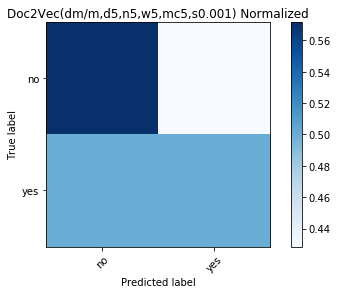

In [49]:
logreg = linear_model.LogisticRegression(n_jobs=1, C=1e5)
logreg = logreg.fit(train_regressors, train_targets)
evaluate_prediction(logreg.predict(test_regressors), test_targets, title=str(doc2vec_model))

2017-02-12 20:16:41,770 : INFO : precomputing L2-norms of doc weight vectors


accuracy 0.503875968992
confusion matrix
 [[27 36]
 [28 38]]
(row=expected, col=predicted)
CPU times: user 211 ms, sys: 124 ms, total: 335 ms
Wall time: 216 ms


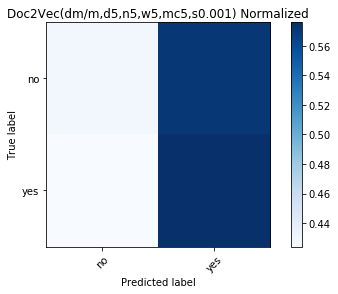

In [50]:
%%time 
knn_test_predictions = [
    doc2vec_model.docvecs.most_similar([pred_vec], topn=1)[0][0]
    for pred_vec in test_regressors
]
evaluate_prediction(knn_test_predictions, test_targets, str(doc2vec_model))

Fitting a random forest to labeled training data...
accuracy 0.565891472868
confusion matrix
 [[37 26]
 [30 36]]
(row=expected, col=predicted)


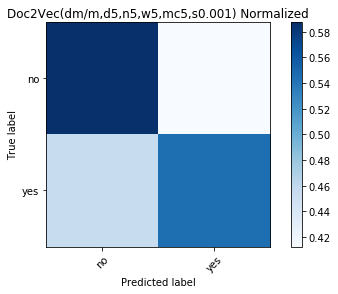

In [51]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier( n_estimators = 100 )

print "Fitting a random forest to labeled training data..."
forest = forest.fit( train_regressors, train_data["conscientiousness_m"] )

# Test & extract results 
result = forest.predict( test_regressors )

evaluate_prediction(result, test_targets, str(doc2vec_model))